# House Value Prediction Model

This project explores a California Housing dataset from "Sparse Spatial Autoregressions" by Pace, R. Kelley and Ronald Barry. Besides a detailed analysis of the dataset, I apply and fine-tune machine learning models to predict housing prices. Good house value prediction models could not only create significant business values for real estate companies but empower individuals to make better investment decisions.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

## Read Data

In [2]:
housing = pd.read_csv("dataset/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## A Quick Look into the Data

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that the "total_bedrooms" attribute has 207 missing values, and that the "ocean_proximity" attribute is the only attribute with *object* type.

In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We now know that "ocean_proximity" is actually a categorical attribute.

/Users/dianyu/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/dianyu/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/dianyu/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/dianyu/opt/anaconda

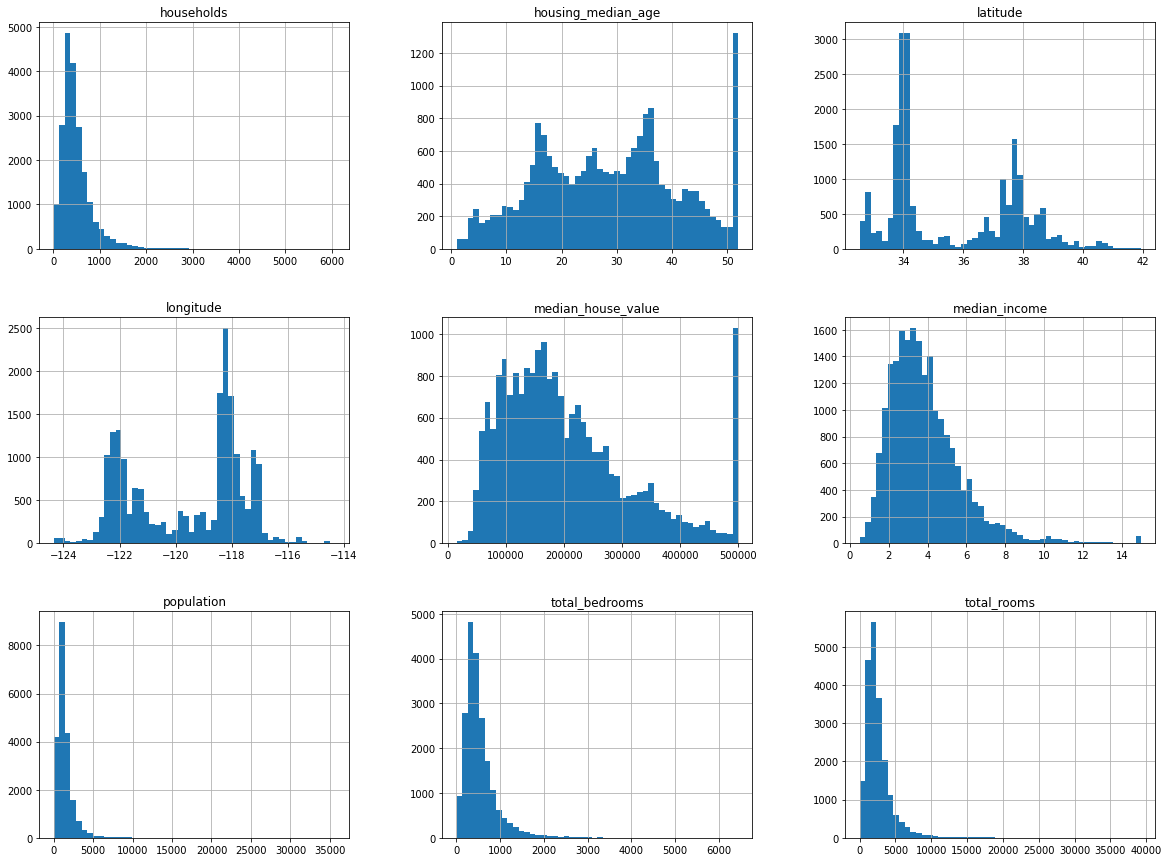

In [5]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Notice that:
1. The "median_income" attribute seems to be scaled and capped at 15.
2. The "housing_median_age" and "median_house_value" attributes are also capped.
3. Attributes have very different scale, and many attributes have right-skewed distributions.

## Exploratory Data Analysis

In [6]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing = train_set.copy()

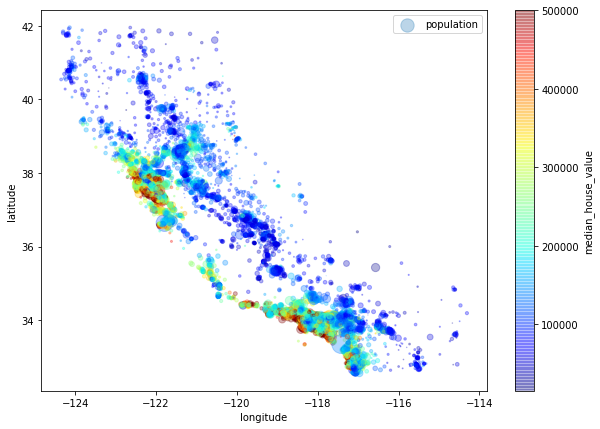

In [7]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.3,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

As we can observe, population and location attributes are probably closely related with house values.

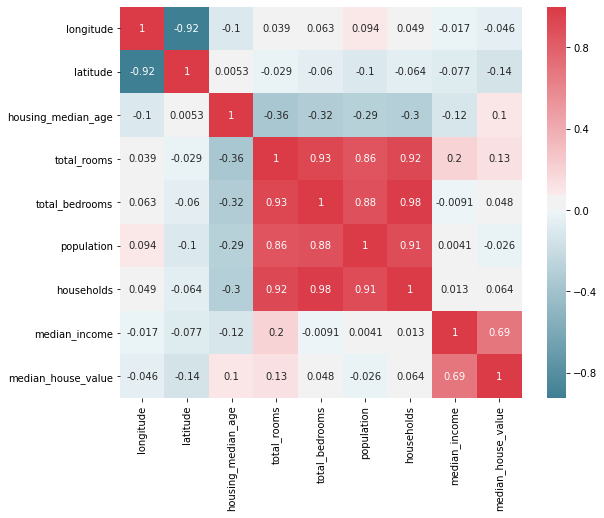

In [8]:
corr_matrix = housing.corr()
plt.figure(figsize=(9, 7.2)) 
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 10, n=10000))
plt.show()

In [9]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
Name: median_house_value, dtype: float64

Notice that "median_income", "total_rooms", "housing_median_age", and "latitude" have the strongest correlations with "median_house_value", in which "median_income" seems to be the most promising attibute to predict house values by far.

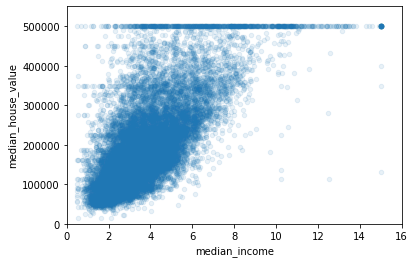

In [10]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
plt.show()

## Feature Engineering

In [11]:
housing.loc[:, "rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing.loc[:, "bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]

In [12]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.690647
rooms_per_household    0.158485
total_rooms            0.133989
housing_median_age     0.103706
households             0.063714
total_bedrooms         0.047980
population            -0.026032
longitude             -0.046349
latitude              -0.142983
bedrooms_per_room     -0.257419
Name: median_house_value, dtype: float64

By combining the "total_rooms" attribute with "households" and "total_bedrooms", we see that our new attributes "rooms_per_household" and "bedrooms_per_room" are more correlated with the median house values than the original attributes.

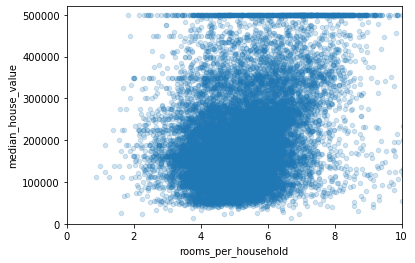

In [13]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 10, 0, 520000])
plt.show()

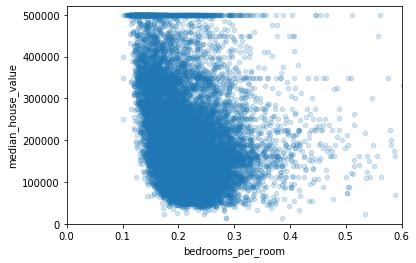

In [14]:
housing.plot(kind="scatter", x="bedrooms_per_room", y="median_house_value",
             alpha=0.2)
plt.axis([0, 0.6, 0, 520000])
plt.show()

## Data Cleaning and Preparation

In [15]:
#Separate attributes and labels
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()

In [16]:
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

This function adds "rooms_per_household" and "population_per_household" features to the dataset.

In [17]:
num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")), #Fill missing values
        ("attribs_adder", FunctionTransformer(add_extra_features, validate=False)), #Add extra attributes
        ("std_scaler", StandardScaler()), #Standardization
    ])

This pipeline:
1. Fills missing values with median values;
2. Adds extra features as mentioned above;
3. Standardizes numerical attributes.

In [18]:
num_attribs = list(housing.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs), #One-hot encoding
    ])

In addition to the previous pipeline, this full pipeline encode our categorical attribute "ocean_proximity" into one-hot vectors.

In [19]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

## Train and Compare Models

Train several models and select the one with the best performance. I look at different models' Root Mean Squred Error (RMSE) on both the training set and 10-fold cross validation set, with a focus on the cross validation RMSE. The lower the RMSE score is, the better the model performs.

In [20]:
housing_prepared

array([[ 1.27258656, -1.3728112 ,  0.34849025, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.70916212, -0.87669601,  1.61811813, ...,  0.        ,
         0.        ,  1.        ],
       [-0.44760309, -0.46014647, -1.95271028, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.59946887, -0.75500738,  0.58654547, ...,  0.        ,
         0.        ,  0.        ],
       [-1.18553953,  0.90651045, -1.07984112, ...,  0.        ,
         0.        ,  0.        ],
       [-1.41489815,  0.99543676,  1.85617335, ...,  0.        ,
         1.        ,  0.        ]])

In [21]:
def calculate_training_score(model):
    model.fit(housing_prepared, housing_labels)
    housing_predictions = model.predict(housing_prepared)
    mse = mean_squared_error(housing_labels, housing_predictions)
    return np.sqrt(mse)

def calculate_cross_val_scores(model):
    mse = cross_val_score(model, housing_prepared, housing_labels, 
                          scoring="neg_mean_squared_error", cv=10)
    rmse = np.sqrt(-mse)
    return rmse

def display_scores(model):
    training_score = calculate_training_score(model)
    cross_val_scores = calculate_cross_val_scores(model)
    print("Training RMSE:", training_score)
    print("Cross Validation RMSE:", cross_val_scores.mean())

In [22]:
lin_reg = LinearRegression()
print("Linear Regression")
display_scores(lin_reg)

Linear Regression
Training RMSE: 67593.20745775253
Cross Validation RMSE: 67828.38677377408


In [23]:
forest_reg = RandomForestRegressor(n_estimators=8, random_state=42)
print("Random Forest")
display_scores(forest_reg)

Random Forest
Training RMSE: 22620.734381293572
Cross Validation RMSE: 53100.956393261054


In [24]:
gb_reg = HistGradientBoostingRegressor(random_state=42)
print("Gradient Boosting")
display_scores(gb_reg)

Gradient Boosting
Training RMSE: 38972.236050890024
Cross Validation RMSE: 46349.89247648082


As one may observe, the Gradient Boosting Regressor has the best performance among the models tested. However, it is worthy to note that the Gradient Boosting Regressor's performance on the training set is slightly better than its performance on the cross validation set, meaning that the model is slightly overfitting the training set and requires hyperparameter tuning.

## Fine-tune Model

In [25]:
param_grid = {"max_iter": [50, 100, 200], "learning_rate": [0.01, 0.1], "max_depth": [3, 6]}

gb_reg = HistGradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_reg, param_grid, cv=10, scoring="neg_mean_squared_error")
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=HistGradientBoostingRegressor(l2_regularization=0.0,
                                                     learning_rate=0.1,
                                                     loss='least_squares',
                                                     max_bins=256,
                                                     max_depth=None,
                                                     max_iter=100,
                                                     max_leaf_nodes=31,
                                                     min_samples_leaf=20,
                                                     n_iter_no_change=None,
                                                     random_state=42,
                                                     scoring=None, tol=1e-07,
                                                     validation_fraction=0.1,
                                                     verbose=0),
        

In [26]:
grid_search.best_estimator_

HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.1,
                              loss='least_squares', max_bins=256, max_depth=6,
                              max_iter=200, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=42, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0)

## Evaluate Final Model

In [27]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

45398.18896525658

In [28]:
data = {"True Value": y_test, "Prediction": np.round(final_predictions, 1)}
pred = pd.DataFrame(data).reset_index(drop = True)
pred.loc[:, "Abs Diff"] = pred["True Value"] - pred["Prediction"]
pred.loc[:, "Percentage Diff (%)"] = (pred["Abs Diff"]/pred["True Value"])*100
pred.sample(10, random_state = 1)

,True Value,Prediction,Abs Diff,Percentage Diff (%)
123,208800.0,211003.6,-2203.6,-1.055364
3455,335000.0,299774.1,35225.9,10.515194
416,500001.0,444650.4,55350.6,11.070098
2084,64900.0,64687.5,212.5,0.327427
718,376600.0,318832.6,57767.4,15.339193
1373,107100.0,98916.1,8183.9,7.641363
17,187500.0,178355.6,9144.4,4.877013
3705,234200.0,271319.9,-37119.9,-15.849658
2343,262500.0,249664.2,12835.8,4.889829
644,331800.0,392919.4,-61119.4,-18.420555


As one may observe, the fine-tuned model gives us reasonably good predictions on the testing set. 

Thank you for reading to the end of this project!